In [1]:
import json
import random
#import balance
#import visualize
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import grammar as g
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from scipy import stats

In [2]:
def pickleDump(var, destination):
    f = open(destination,"wb")
    pickle.dump(var,f)
    f.close() 
    
    
def pickleLoad(path):
    file = open(path, 'rb')
    info = pickle.load(file)
    file.close()
    return info

def loadMetrics(title, d_path, group, balanced):
    if type(balanced) == bool:
        print("balanced should be text")
        return
    path = '../exports/%s/metrics/%s/%s/%s.pkl' % (d_path, balanced, group, title)
    
    return pickleLoad(path)



In [3]:

IDX = pickleLoad('../../data/IDX.pkl')
PP = pickleLoad('../../data/pres_part.pkl')
PRES = pickleLoad('../../data/present.pkl')
ENG = pickleLoad('../../data/eng.pkl')
PAST = pickleLoad('../../data/past.pkl')

In [4]:
train_stsgs = pickleLoad('../../data/stsgs/train_stsgs.pkl')
test_stsgs = pickleLoad('../../data/stsgs/test_stsgs.pkl')

In [5]:

with open('../../data/template_ids.txt') as json_file:
    templ_ids_dict = json.load(json_file)
    
templ_ids = []

for i in templ_ids_dict:
    templ_ids.append(i)

In [6]:
with open('../../data/templ2global.txt', 'r') as f:
    templ2global = json.load(f)

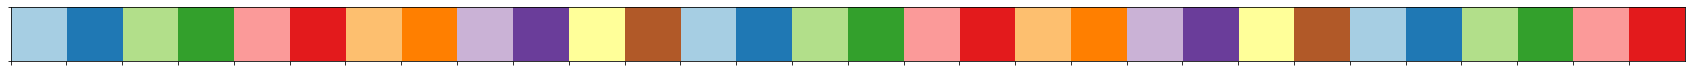

In [7]:

palettes = ['BuPu', 'PuOr_r', 'RdBu', 'RdBu_r', 'RdGy_r', 'Set3', 'afmhot', 'afmhot_r', 'seismic', 'seismic_r', 'tab20c', 'twilight_shifted', 'vlag_r']

palettes_v2 = ['BrBG', 'BrBG_r', 'PuOr', 'PuOr_r', 'twilight_shifted', 'twilight_shifted_r']
#for p in palettes:
#    prin
col = 'Paired'#'Dark2_r'#'vlag' # want it to be more distinct for all of them
colors = sns.color_palette(col, 30)
sns.palplot(sns.color_palette(col, 30))

# Get the data

In [8]:
with open('../../exports/dataset/results/balanced_agqa_preds/preds_hcrn.json', 'r') as f:
    hcrn_preds = json.load(f)

with open('../../exports/dataset/results/balanced_agqa_preds/preds_hme.json', 'r') as f:
    hme_preds = json.load(f)


with open('../../exports/dataset/results/balanced_agqa_preds/preds_psac.json', 'r') as f:
    psac_preds = json.load(f)

with open('../../exports/dataset/results/blind_agqa_preds/preds_hcrn.json', 'r') as f:
    hcrn_blind_preds = json.load(f)

with open('../../exports/dataset/results/blind_agqa_preds/preds_hme.json', 'r') as f:
    hme_blind_preds = json.load(f)


with open('../../exports/dataset/results/blind_agqa_preds/preds_psac.json', 'r') as f:
    psac_blind_preds = json.load(f)

    

In [9]:
# step 1: put into by video

def sortByVideo(preds):
    by_v = {}

    for p in preds:
        v_id = p['csv_q_id'][:5]
        if v_id not in by_v:
            by_v[v_id] = []
        by_v[v_id].append(p)
            
    return by_v


In [10]:
def formatPreds(by_v):
    # step 2: go through each videoqs and get the num steps per question also the template
    for v in by_v:
        ps = by_v[v]

        with open('../../exports/dataset/balanced/test/%s.txt' % v, 'r') as f:
            QA = json.load(f)

        for p in ps:
            q_id = p['csv_q_id']
            q = QA[q_id]

            p['steps'] = q['steps']
            p['type'] = q['attributes']['type']
            p['struct'] = q['attributes']['structural']
            
    return by_v
        

In [11]:
preds = [hcrn_preds, hme_preds, psac_preds]
by_v = [sortByVideo(i) for i in preds]
by_v = [formatPreds(i) for i in by_v]

In [12]:
preds_blind = [hcrn_blind_preds, hme_blind_preds, psac_blind_preds]
by_v_blind = [sortByVideo(i) for i in preds_blind]
by_v_blind = [formatPreds(i) for i in by_v_blind]

# Analysis functions

In [13]:
# function for getting accuracy of list

def acc(ps):
    cor = 0
    for p in ps:
        if p['prediction'] == p['answer']:
            cor += 1
            
    return round(cor / len(ps) * 100, 2)


In [14]:
# step 3: sort by template, answer, and num steps etc
def giveTrue(p):
    return True

def sortSteps(by_v, qual=giveTrue):
    sort_steps = {}

    for v in by_v:
        ps = by_v[v]

        for p in ps:
            s = p['steps']
            if qual(p):

                if s not in sort_steps:
                    sort_steps[s] = []
                sort_steps[s].append(p)
                
                
    return sort_steps


In [15]:
def makeDicts(sort_steps):
    steps = []
    for i in sort_steps:
        x = {'steps': i, 'acc': acc(sort_steps[i]), 'number': len(sort_steps[i])}
        steps.append(x)

    return steps
    

def process(by_v, f=giveTrue):

    sort_steps = [sortSteps(i, qual=f) for i in by_v]
    sort_steps = [makeDicts(i) for i in sort_steps]
    
    dfs = [pd.DataFrame(i) for i in sort_steps]
    
    for df in dfs:
        df['number_adj'] = df['number'] / 100
    
    return sort_steps, dfs
    

In [16]:
def isBinary(p):
    return p['struct'] != 'query'


def isOpen(p):
    return p['struct'] == 'query'


def isObjWhat(p):
    return p['type'] == 'objWhat'

def isObjFirst(p):
    return p['type'] == 'objFirst'

def isObjLast(p):
    return p['type'] == 'objLast'

In [17]:
def r2scoreold(df):
    return r2_score(df.steps.values, df.acc.values)

def r2(df):
    return stats.pearsonr(df.steps.values, df.acc.values)[0] ** 2
    

In [18]:
def getF(name):
    if name == 'Binary':
        return isBinary
        
    elif name == 'Open':
        return isOpen
    
    elif name == 'objFirst':
        return isObjFirst
    elif name == 'objLast':
        return isObjLast
    elif name == 'objWhat':
        return isObjWhat
        
    else:
        return

# Visualizations

In [30]:
def plot(dfs, name, blind=False, save=True):
    f = getF(name)
        
    if f is None:
        print("invalid name %s" % name)
        return
    
    if blind:
        proper_by_v = by_v_blind
        title = '%s Accuracy and Steps (w/o vision)' % name
        name = name + '-blind'
    else:
        proper_by_v = by_v
        title = '%s Accuracy and Steps' % name
        
        
        
    sort_steps, dfs = process(proper_by_v, f=f)
    hcrn_df, hme_df, psac_df = dfs
    
    size = 10
    plt.subplots(figsize=(size, size))

    p = sns.regplot(x="steps", y='acc', data=hcrn_df, color=colors[7], scatter_kws={'s': hcrn_df['number_adj']})#, linewidth=lw)#int(len(colors) * .3)])
    p = sns.regplot(x="steps", y='acc', data=hme_df, color=colors[1], scatter_kws={'s': hme_df['number_adj']})#, linewidth=lw)#int(len(colors) * .5)])
    p = sns.regplot(x="steps", y='acc', data=psac_df, color=colors[9], scatter_kws={'s': psac_df['number_adj']})#, linewidth=lw)#int(len(colors) * .7)])
    
    if 'Open' in name:
        print("adjusting y axis!")
        p.set_ylim(0.0, 50.0)
        
    
    elif 'Binary' in name:
        print("adjusting y axis!")
        p.set_ylim(44.0, 56.0)
        
    else:
        print('Dont adjust y axis')
    
    y = p.get_yticks()
    ##y = [int(i * 100) for i in y]
    y = [int(i) for i in y]
    p.set_yticklabels(y, size = size * 3)
    #ax.set_xticklabels([int(i) for i in ax.get_xticks()], size = size * 3)
    plt.title(title, y=1.05, fontsize=size*4)

    lab = ['HCRN', 'HME', "PSAC"]
    
    plt.xticks(fontsize=size*3)
    plt.yticks(fontsize=size*3)
    plt.xlabel('Compositional Steps', fontsize=size*4)
    plt.ylabel('Accuracy(%)', fontsize=size*4)
        
    p.legend(lab, fontsize='xx-large', frameon=True, labelspacing=.5, handlelength=2.0, prop={'size': size*3})#.texts[0].set_text(labels[0])
    #p.set(xticks=[i + 1 for i in range(10)])
    
    print("R2 score HCRN: %s" % r2(hcrn_df))    
    print("R2 score HME: %s" % r2(hme_df))    
    print("R2 score PSAC: %s" % r2(psac_df))

    if save:
        plt.savefig('../../figures/dataset/accAndCompo/accuracy_and_compo-%s.png' % name, bbox_inches='tight')
    plt.show()
   # bbox_to_anchor=(1, 0.9)

adjusting y axis!
R2 score HCRN: 0.4386002211164895
R2 score HME: 0.5224462299251956
R2 score PSAC: 0.44587718136530774


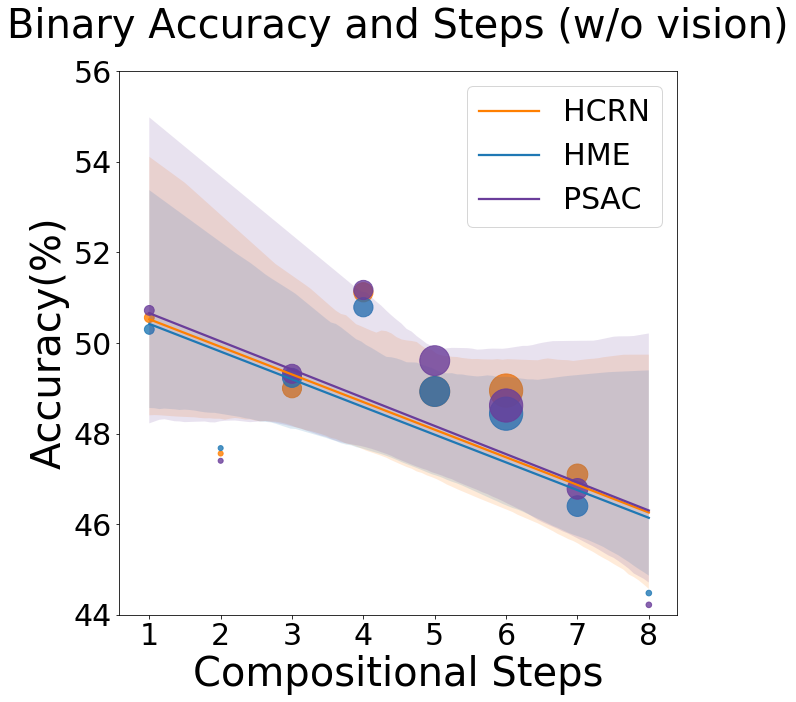

In [37]:
plot(by_v, 'Binary', blind=True, save=False)

adjusting y axis!
R2 score HCRN: 0.6438669667499016
R2 score HME: 0.48633484579327363
R2 score PSAC: 0.514933735906965


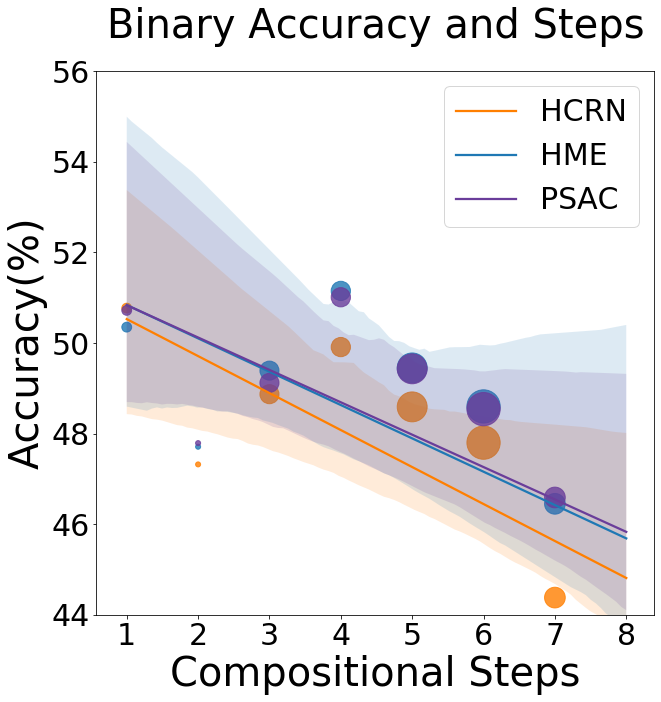

In [167]:
plot(by_v, 'Binary')

adjusting y axis!
R2 score HCRN: 0.41140443295220736
R2 score HME: 0.5165462754173964
R2 score PSAC: 0.44471551730240777


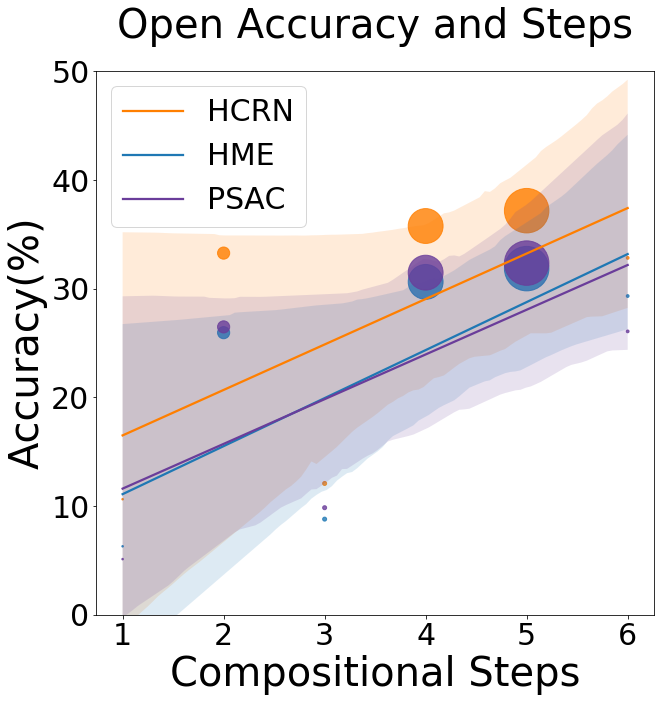

In [168]:
plot(by_v, 'Open')

adjusting y axis!
R2 score HCRN: 0.5851125031552022
R2 score HME: 0.5396736162094014
R2 score PSAC: 0.42017886858191683


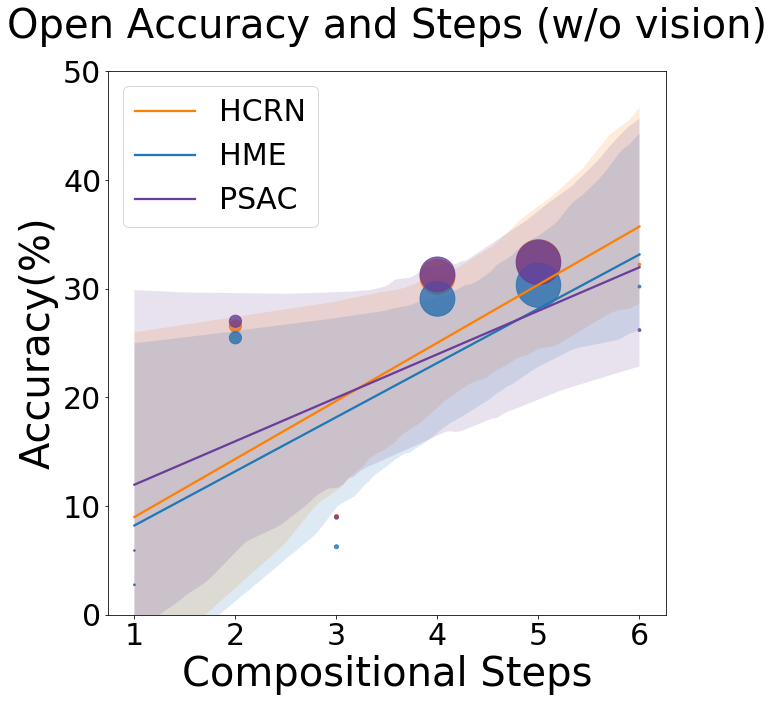

In [169]:
plot(by_v, 'Open', blind=True)

In [ ]:
cutoffhere

R2 score HCRN: 0.5854479320029189
R2 score HME: 0.3048866073121571
R2 score PSAC: 0.37979081108703217


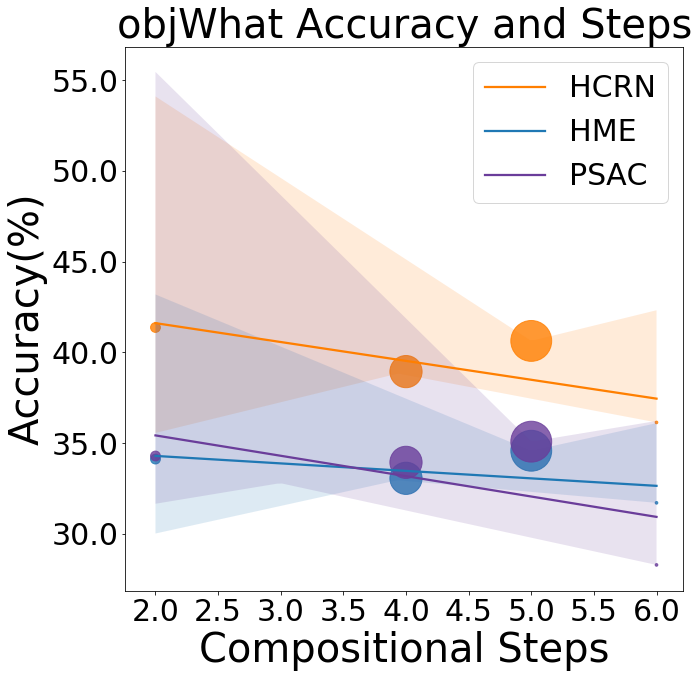

In [146]:
plot(by_v, 'objWhat')

R2 score HCRN: 0.5032284131595951
R2 score HME: 0.33257179492832
R2 score PSAC: 0.03147104655401253


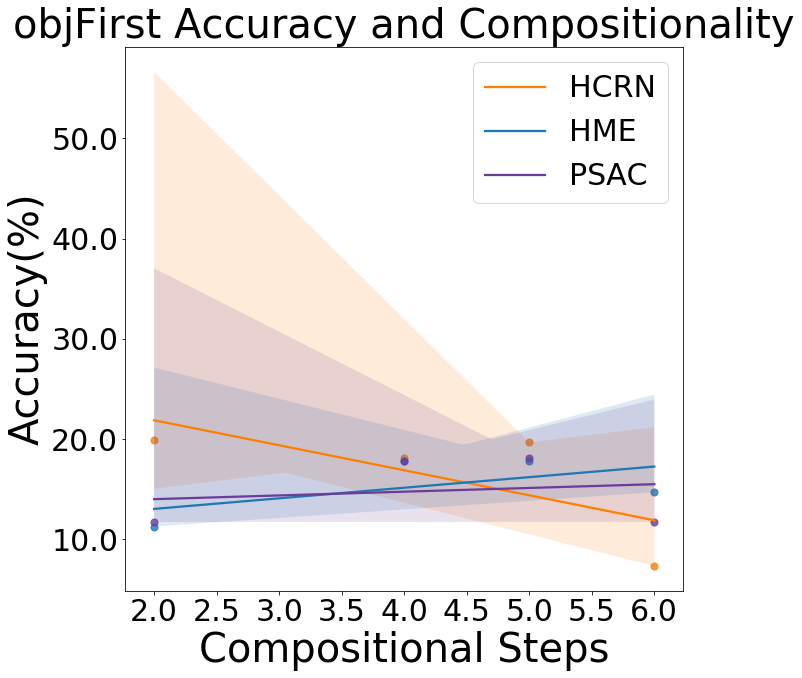

In [100]:
plot(by_v, 'objFirst')

R2 score HCRN: 0.5716719562471548
R2 score HME: 0.039395051098396215
R2 score PSAC: 0.14682321035661125


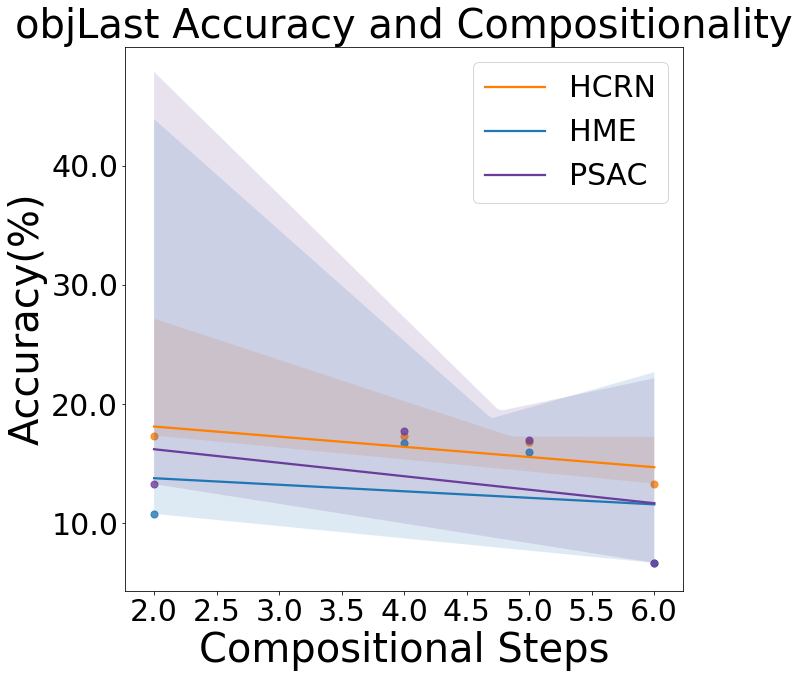

In [101]:
plot(by_v, 'objLast')

# TODO

Make the size of the dots proportional

Add the blind models?

In [39]:
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x="day", y="total_bill", data=tips)

AttributeError: module 'seaborn' has no attribute 'set_theme'

# Delete everything under here

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [23]:
df = pd.read_csv('../../../datavis/A1/sunshine.csv')

In [24]:
df

,city,lon,lat,month,monthnum,sunshine
0,Chicago,-87.623177,41.881832,Jan,0,135
1,Chicago,-87.623177,41.881832,Feb,1,136
2,Chicago,-87.623177,41.881832,Mar,2,187
3,Chicago,-87.623177,41.881832,Apr,3,215
4,Chicago,-87.623177,41.881832,May,4,281
...,...,...,...,...,...,...
67,Seattle,-122.335167,47.608013,Aug,7,281
68,Seattle,-122.335167,47.608013,Sep,8,221
69,Seattle,-122.335167,47.608013,Oct,9,142
70,Seattle,-122.335167,47.608013,Nov,10,72


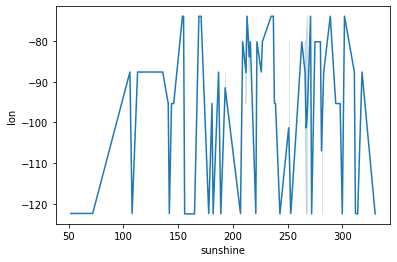

In [26]:
sns.lineplot(data=df, x='sunshine', y='lon')

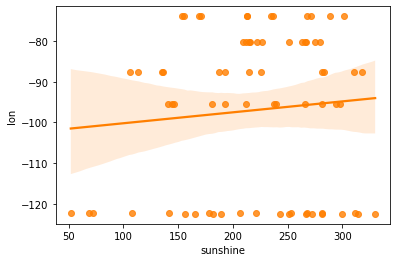

In [36]:
p = sns.regplot(x='sunshine', y='lon', data=df, color=colors[7])